In [1]:
# pip install yfinance

In [2]:
import logging
import warnings
import os
import sys
sys.stderr = open("error.txt", "w") 
warnings.filterwarnings("ignore")
import numpy as np
import cvxpy as cp
import pandas as pd
import xgboost as xgb
import yfinance as yf
import seaborn as sns
import pandas_ta as ta
import quantstats as qs
from datetime import datetime
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import balanced_accuracy_score, classification_report
from dataclasses import dataclass
from datetime import datetime, timedelta


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sk

In [3]:
def standardize_dates(df, date_col='Date'):
    for i in range(len(df)):
        date_str = df.loc[i, 'Date']
        day, month, year = date_str.split('/')
        if len(year) == 2:
            year = '20' + year
        df.loc[i, 'Date'] = f"{day}/{month}/{year}"

    df[date_col] = pd.to_datetime(df[date_col], format="%d/%m/%Y")
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)
    return df

In [4]:

def regime_to_portfolio_returns(df, return_col,regime_col='Oracle', t_bills_col='US3MBill'):

    df = df.copy()

    if t_bills_col in df.columns:
        df['tbill_daily'] = df[t_bills_col] / 100.0 / 252.0
    else:
        df['tbill_daily'] = 0.0

    df['daily_return_shifted'] = df[return_col].shift(-1)
    df['tbill_daily_shifted'] = df['tbill_daily'].shift(-1)
    df['strategy_return'] = 0.0
    df.loc[df[regime_col] == 1, 'strategy_return'] =  df['daily_return_shifted']
    df.loc[df[regime_col] == -1, 'strategy_return'] = -df['daily_return_shifted']
    df.loc[df[regime_col] == 0, 'strategy_return'] =  df['tbill_daily_shifted']
    df['strategy_return'] = df['strategy_return'].fillna(0)
    return df['strategy_return']


In [5]:
def create_oracle_labels(data, threshold=0.15, neutral_window=7):
    data = data.copy()
    data['Date'] = data.index
    data.reset_index(drop=True, inplace=True)
    data['regime'] = 'Neutral'
    data['Oracle'] = 0
    peaks_troughs = []
    current_type = 'peak'
    hi = data['Close'].iloc[0]
    lo = data['Close'].iloc[0]
    hi_idx = 0
    lo_idx = 0
    for i in range(1, len(data)):
        Close = data['Close'].iloc[i]
       
        if current_type == 'peak' :
            if hi <= Close:
                hi = Close
                hi_idx = i
               
            elif Close <= hi * (1 - threshold):
                peaks_troughs.append(('peak', hi_idx))
                lo = Close
                hi = Close
                lo_idx = i
                current_type = 'trough'
        elif current_type == 'trough':
            if lo >= Close:
                lo = Close
                lo_idx = i
            elif Close >= lo * (1 + threshold):
                peaks_troughs.append(('trough', lo_idx))
                hi = Close
                lo = Close
                hi_idx = i
                current_type = 'peak'
    regimes = []
    prev_idx = 0
    for pt in peaks_troughs:
        pt_type, pt_idx = pt
        regimes.append({
            'start_idx': prev_idx,
            'end_idx': pt_idx,
            'regime': 'Bear' if pt_type == 'trough' else 'Bull'
        })
        prev_idx = pt_idx
   
   
    regimes.append({
        'start_idx': prev_idx,
        'end_idx': len(data)-1,
        'regime': 'Bear' if current_type == 'trough' else 'Bull'
    })
    for r in regimes:
        data.iloc[r['start_idx']:r['end_idx']+1, data.columns.get_loc('regime')] = r['regime']
   
    switches = data[data['regime'] != data['regime'].shift(1)].index
    neutral_zones = []
    for switch in switches:
        start = max(0, switch - neutral_window)
        end = min(len(data)-1, switch + neutral_window)
        neutral_zones.extend(list(range(start, end+1)))

    data.iloc[neutral_zones, data.columns.get_loc('regime')] = 'Neutral'
    for i in range(len(data)):
        data.iloc[i, data.columns.get_loc('Oracle')] = 1 if data['regime'][i] == 'Bull' else -1 if data['regime'][i] == 'Bear' else 0
    data['Oracle'] = data['Oracle'].shift(-1)
    data.set_index('Date', inplace=True)
   
    data = data.dropna(how="any")
    return data


In [6]:

def compute_quantstats_metrics(ret_series):

    s = ret_series.dropna()
    metrics = {}
    metrics['Annualized Return (%)'] = qs.stats.cagr(s) * 100
    metrics['Cumulative Return (%)'] = qs.stats.comp(s) * 100  
    metrics['Annualized Risk (%)'] = qs.stats.volatility(s) * 100
    metrics['Max Drawdown (%)'] = qs.stats.max_drawdown(s) * 100
    metrics['Ulcer Index (%)'] = qs.stats.ulcer_index(s) * 100
    metrics['Sharpe Ratio'] = qs.stats.sharpe(s)
    metrics['Sortino Ratio'] = qs.stats.sortino(s)
    metrics['Calmar Ratio'] = qs.stats.calmar(s)
    metrics['Gain/Pain Ratio'] = qs.stats.gain_to_pain_ratio(s)
    metrics['Win Rate (%)'] = qs.stats.win_rate(s) * 100
    metrics['Profit Factor'] = qs.stats.profit_factor(s)
    
    return metrics

In [7]:
def kuipers_score(true_states, pred_states):
    ts = np.array(true_states)
    ps = np.array(pred_states)
    bull_tp = np.sum((ts == 1) & (ps == 1))   
    bull_fn = np.sum((ts == 1) & (ps != 1))   
    bull_recall = bull_tp / (bull_tp + bull_fn) if (bull_tp + bull_fn) > 0 else 0
    bear_tp = np.sum((ts == -1) & (ps == -1)) 
    bear_fp = np.sum((ts != -1) & (ps == -1)) 
    bear_fdr = bear_fp / (bear_fp + bear_tp) if (bear_fp + bear_tp) > 0 else 0
    return bull_recall - bear_fdr


In [8]:
def state_proportions(arr):
    total = len(arr)
    return {
        'Bull %':    f"{100*np.sum(arr==1)/total:.2f}%",
        'Neutral %': f"{100*np.sum(arr==0)/total:.2f}%",
        'Bear %':    f"{100*np.sum(arr==-1)/total:.2f}%"
    }

In [9]:
def plot_regimes(df, regime_col='Oracle', title='Regime Plot'):
    plt.figure(figsize=(10, 4))
    plt.plot(df['Close'], label='Close', color='black')
    bull_mask = (df[regime_col] == 1)
    bear_mask = (df[regime_col] == -1)
    neutral_mask = (df[regime_col] == 0)
    plt.fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=bull_mask, alpha=0.5, label='Bull')
    plt.fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=bear_mask, alpha=0.5, label='Bear')
    plt.fill_between(df.index, df['Close'].min(), df['Close'].max(),
                     where=neutral_mask, alpha=0.5, label='Neutral')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{title}_regime_plot.png')
    plt.show()

In [10]:
def calculate_max_drawdown(returns):
    """Calculate the maximum drawdown from a series of returns"""
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max) - 1
    return drawdown.min()

In [11]:
def plot_strategies_performance(df, strategy_cols, title='Cumulative Returns'):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    import matplotlib.cm as cm


    plt.figure(figsize=(12, 6))

   
    cmap = cm.get_cmap('tab10', len(strategy_cols))

    for i, (label, col) in enumerate(strategy_cols.items()):
       
        if isinstance(col, str):
            if col not in df.columns:
                print(f"Column '{col}' for strategy '{label}' not found in DataFrame.")
                continue
            returns_series = df[col]
        elif hasattr(col, 'index'):
            returns_series = col
        else:
            print(f"Invalid data for strategy '{label}'.")
            continue

       
        cum_returns = (1 + returns_series).cumprod() - 1

       
        plt.plot(cum_returns.index, cum_returns * 100,
                 label=label,
                 linewidth=2,
                 marker='o',
                 markersize=2,
                 color=cmap(i))
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter()) 
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()
    
   
    summary = {}
    for label, col in strategy_cols.items():
        if isinstance(col, str) and col in df.columns:
            returns = df[col]
        elif hasattr(col, 'index'):
            returns = col
        else:
            continue
            
        final_return = ((1 + returns).cumprod() - 1).iloc[-1] * 100
        summary[label] = {
            'Final Return (%)': round(final_return, 2),
            'Max Drawdown (%)': round(calculate_max_drawdown(returns) * 100, 2)
        }
    
    return pd.DataFrame(summary).T


In [12]:
start_date = "2010-03-01"
end_date = "2025-01-01"

In [13]:
df_russell = pd.read_csv("russell.csv")

In [14]:
for i in range(len(df_russell)):
        date_str = df_russell.loc[i, 'Date']
        day, month, year = date_str.split('/')
        if len(year) == 2:
            year = '20' + year
        df_russell.loc[i, 'Date'] = f"{day}/{month}/{year}"

In [15]:
df_russell['Date'] = pd.to_datetime(df_russell['Date'], format="%d/%m/%Y")

In [16]:
df_russell.set_index('Date', inplace=True)
df_russell = df_russell.loc[start_date:end_date]

In [17]:
df_russell['daily_return'] = df_russell['Close'].pct_change()
df_russell['daily_volatility'] = df_russell['daily_return'].rolling(window=20).std()
df_russell['ewma_return_20'] = df_russell['daily_return'].ewm(span=20, adjust=False).mean()
df_russell['ewma_return_50'] = df_russell['daily_return'].ewm(span=50, adjust=False).mean()
df_russell['daily_range'] = df_russell['High'] - df_russell['Low']
df_russell['momentum_14'] = ta.mom(df_russell['Close'], length=14)
macd_df = ta.macd(df_russell['Close'])
df_russell['macd'] = macd_df['MACD_12_26_9']
df_russell['macd_diff'] = macd_df['MACDh_12_26_9']
df_russell['macd_signal'] = macd_df['MACDs_12_26_9']
bband_df = ta.bbands(df_russell['Close'], length=20, std=2)
df_russell['bollinger_upper'] = bband_df['BBU_20_2.0']
df_russell['bollinger_lower'] = bband_df['BBL_20_2.0']
df_russell['dpo'] = ta.dpo(df_russell['Close'], length=20)
df_russell['ema_14'] = ta.ema(df_russell['Close'], length=14)
df_russell['atr_14'] = ta.atr(df_russell['High'], df_russell['Low'], df_russell['Close'], length=14)
df_russell.dropna(inplace=True)



In [18]:
df_combined = pd.DataFrame()
df_combined['Date'] = pd.date_range(start=start_date, end=end_date,freq='B')


In [19]:
df_russell.shape

(3663, 19)

In [20]:
df_russell = df_russell.reindex(df_combined['Date'])

In [21]:
print(df_russell.isnull().value_counts())
df_russell = df_russell.fillna(method='ffill')

Close  High   Low    Open   Volume  daily_return  daily_volatility  ewma_return_20  ewma_return_50  daily_range  momentum_14  macd   macd_diff  macd_signal  bollinger_upper  bollinger_lower  dpo    ema_14  atr_14
False  False  False  False  False   False         False             False           False           False        False        False  False      False        False            False            False  False   False     3663
True   True   True   True   True    True          True              True            True            True         True         True   True       True         True             True             True   True    True       210
Name: count, dtype: int64


In [22]:
df_russell.isnull().value_counts()

Close  High   Low    Open   Volume  daily_return  daily_volatility  ewma_return_20  ewma_return_50  daily_range  momentum_14  macd   macd_diff  macd_signal  bollinger_upper  bollinger_lower  dpo    ema_14  atr_14
False  False  False  False  False   False         False             False           False           False        False        False  False      False        False            False            False  False   False     3839
True   True   True   True   True    True          True              True            True            True         True         True   True       True         True             True             True   True    True        34
Name: count, dtype: int64

In [23]:
df_etf_ishares = pd.read_csv("russell_etf_ishres.csv")

In [24]:
df_etf_van = pd.read_csv("russell_etf_van.csv")

ishares

In [25]:
for i in range(len(df_etf_ishares)):
        date_str = df_etf_ishares.loc[i, 'Date']
        day, month, year = date_str.split('/')
        if len(year) == 2:
            year = '20' + year
        df_etf_ishares.loc[i, 'Date'] = f"{day}/{month}/{year}"
df_etf_ishares['Date'] = pd.to_datetime(df_etf_ishares['Date'], format="%d/%m/%Y")
df_etf_ishares.set_index('Date', inplace=True)
df_etf_ishares = df_etf_ishares.loc[start_date:end_date]

In [26]:
df_etf_van['Date'] = pd.to_datetime(df_etf_van['Date'], format="%Y-%m-%d")
df_etf_van.set_index('Date', inplace=True)
df_etf_van = df_etf_van.loc[start_date:end_date]

In [27]:
df_etf_ishares['etf_daily_return_ishares'] = df_etf_ishares['Close'].pct_change()
df_etf_van['etf_daily_return_van'] = df_etf_van['Close'].pct_change()

In [28]:
df_etf_ishares = df_etf_ishares.reindex(df_combined['Date'])
df_etf_van = df_etf_van.reindex(df_combined['Date'])

In [29]:
print(df_etf_ishares.isnull().value_counts())
df_etf_ishares = df_etf_ishares.fillna(method='ffill')
print(df_etf_van.isnull().value_counts())
df_etf_van = df_etf_van.fillna(method='ffill')

Close  High   Low    Open   Volume  etf_daily_return_ishares
False  False  False  False  False   False                       3735
True   True   True   True   True    True                         137
False  False  False  False  False   True                           1
Name: count, dtype: int64
Close  High   Low    Open   Volume  etf_daily_return_van
False  False  False  False  False   False                   3592
True   True   True   True   True    True                     280
False  False  False  False  False   True                       1
Name: count, dtype: int64


In [30]:
df_etf_ishares.fillna(0,inplace=True)
df_etf_van.fillna(0,inplace=True)

In [31]:
df_10yield = pd.read_csv("10yield.csv")

In [32]:
df_10yield

,observation_date,DGS10
0,2000-01-03,6.58
1,2000-01-04,6.49
2,2000-01-05,6.62
3,2000-01-06,6.57
4,2000-01-07,6.52
...,...,...
6569,2025-03-07,4.32
6570,2025-03-10,4.22
6571,2025-03-11,4.28
6572,2025-03-12,4.32


In [33]:
df_10yield['observation_date'] = pd.to_datetime(df_10yield['observation_date'],format='%Y-%m-%d')
df_10yield.set_index('observation_date', inplace=True)
df_10yield = df_10yield.sort_index()
df_10yield = df_10yield[start_date:end_date]

In [34]:
df_10yield = df_10yield.reindex(df_combined['Date'])
print(df_10yield.isnull().value_counts())
df_10yield = df_10yield.fillna(method='ffill')

DGS10
False    3714
True      159
Name: count, dtype: int64


In [35]:
df_5yield = pd.read_csv("5yield.csv")

In [36]:
df_5yield['observation_date'] = pd.to_datetime(df_5yield['observation_date'],format='%Y-%m-%d')
df_5yield.set_index('observation_date', inplace=True)
df_5yield = df_5yield.sort_index()
df_5yield = df_5yield[start_date:end_date]

In [37]:
df_5yield = df_5yield.reindex(df_combined['Date'])
print(df_5yield.isnull().value_counts())
df_5yield = df_5yield.fillna(method='ffill')

DGS2 
False    3714
True      159
Name: count, dtype: int64


In [38]:
df_vix = pd.read_csv("vix.csv")

In [39]:
for i in range(len(df_vix)):
        date_str = df_vix.loc[i, 'Date']
        day, month, year = date_str.split('/')
        if len(year) == 2:
            year = '20' + year
        df_vix.loc[i, 'Date'] = f"{day}/{month}/{year}"

In [40]:
df_vix['Date'] = pd.to_datetime(df_vix['Date'],format='%d/%m/%Y')
df_vix.set_index('Date', inplace=True)
df_vix = df_vix.sort_index()
df_vix = df_vix[start_date:end_date]

In [41]:
df_vix

,Close_VIX,High_VIX,Low_VIX,Open_VIX,Volume_VIX
Date,,,,,
2010-03-01,19.260000,19.940001,19.180000,19.930000,0
2010-03-02,19.059999,19.360001,18.600000,18.830000,0
2010-03-03,18.830000,19.299999,18.420000,18.950001,0
2010-03-04,18.719999,19.270000,18.580000,18.860001,0
2010-03-05,17.420000,18.150000,17.230000,18.059999,0
...,...,...,...,...,...
2024-12-24,14.270000,17.040001,14.270000,16.969999,0
2024-12-26,14.730000,15.930000,14.550000,14.990000,0
2024-12-27,15.950000,18.450001,15.290000,15.380000,0


In [42]:
df_vix = df_vix.reindex(df_combined['Date'])
print(df_vix.isnull().value_counts())
df_vix = df_vix.fillna(method='ffill')

Close_VIX  High_VIX  Low_VIX  Open_VIX  Volume_VIX
False      False     False    False     False         3736
True       True      True     True      True           137
Name: count, dtype: int64


In [43]:
df_vix.isnull().value_counts()

Close_VIX  High_VIX  Low_VIX  Open_VIX  Volume_VIX
False      False     False    False     False         3873
Name: count, dtype: int64

In [44]:
put_call_df = pd.read_csv("pcr_upd.csv")

In [45]:
put_call_df.rename(columns={'Equity P/C Ratio': 'put_call_ratio'}, inplace=True)
put_call_df['Date'] = pd.to_datetime(put_call_df['Date'], format='%Y-%m-%d')

In [46]:
put_call_df.set_index('Date', inplace=True)
put_call_df = put_call_df[start_date:end_date]

In [47]:
put_call_df = put_call_df.reindex(df_combined['Date'])
print(put_call_df.isnull().value_counts())
put_call_df = put_call_df.fillna(method='ffill')

put_call_ratio
False             3873
Name: count, dtype: int64


In [48]:
if 'put_call_ratio' in put_call_df.columns:
    put_call_df['put_call_ratio_lagged'] = put_call_df['put_call_ratio'].shift(1)
    put_call_df.fillna(method='ffill')

In [49]:
oil_df = pd.read_csv("spot_prices.csv")
oil_df['Date'] = pd.to_datetime(oil_df['Date'], format='%b %d %Y')
oil_df.set_index("Date",inplace=True)
oil_df = oil_df[start_date:end_date]
oil_df = oil_df.reindex(df_combined['Date'])
print(oil_df.isnull().value_counts())
oil_df = oil_df.fillna(method='ffill')

spot_price
False         3727
True           146
Name: count, dtype: int64


In [50]:
us_bills_df = pd.read_csv("us_bills.csv")
us_bills_df.rename(columns={"observation_date":"Date"},inplace=True)
us_bills_df['Date'] = pd.to_datetime(us_bills_df['Date'],format = "%Y-%m-%d")
us_bills_df.set_index("Date",inplace=True)
us_bills_df = us_bills_df[start_date:end_date]
us_bills_df = us_bills_df.reindex(df_combined['Date'])
print(us_bills_df.isnull().value_counts())
us_bills_df = us_bills_df.fillna(method='ffill')

DTB3 
False    3714
True      159
Name: count, dtype: int64


In [51]:
df_sp = pd.read_csv("s&p_total_ret.csv")
df_sp["Date"] = pd.to_datetime(df_sp['Date'],format="%m/%d/%Y")
df_sp.set_index("Date",inplace=True)
df_sp = df_sp.reindex(df_combined['Date'])
print(df_sp.isnull().value_counts())
df_sp = df_sp.fillna(method='ffill')
df_sp.rename(columns={"Close":"s&p_index"},inplace=True)
df_sp['sp_returns'] = df_sp['s&p_index'].pct_change()
df_sp['s&p_rsi'] = ta.rsi(df_sp['s&p_index'])
df_sp['s&p_ewma_20'] = df_sp['sp_returns'].ewm(span=20, adjust=False).mean()
df_sp['s&p_ewma_50'] = df_sp['sp_returns'].ewm(span=50, adjust=False).mean()

Close
False    3735
True      138
Name: count, dtype: int64


In [52]:
df_short = pd.read_csv("nyse_short_term.csv")
df_short.rename(columns={"Close":"short_term_index"},inplace=True)
df_short["Date"] = pd.to_datetime(df_short['Date'],format="%m/%d/%Y")
df_short.set_index("Date",inplace=True)
df_short = df_short.reindex(df_combined['Date'])
print(df_short.isnull().value_counts())
df_short = df_short.fillna(method='ffill')

Ticker  short_term_index
False   False               3735
True    True                 138
Name: count, dtype: int64


In [53]:
train_start_date = start_date
test1_start_date = pd.to_datetime("2015-03-13")
test2_start_date = pd.to_datetime("2020-02-01")
last_date = end_date

In [54]:
df_10yield.rename(columns={"DGS10":"10_year_yield"},inplace=True)

In [55]:
df_vix.rename(columns={"Close_VIX":"VIX"},inplace=True)

In [56]:
df_russell['yield_ratio'] = df_10yield['10_year_yield'] / df_5yield['DGS2']


In [57]:
oil_df.rename(columns={"spot_price":"oil_spot_price"},inplace=True)

In [58]:
us_bills_df.rename(columns={"DTB3":"US3MBill"},inplace=True)

In [59]:
df_uncertainity = pd.read_csv("equity_uncertainity.csv")
df_uncertainity["Date"] = pd.to_datetime(df_uncertainity['Date'],format="%m/%d/%Y")
df_uncertainity.set_index("Date",inplace=True)
df_uncertainity = df_uncertainity.reindex(df_combined['Date'])
print(df_uncertainity.isnull().value_counts())
df_uncertainity = df_uncertainity.fillna(method='ffill')
df_uncertainity.rename(columns={"Close":"uncertainity"},inplace=True)

Ticker  Close
False   False    3873
Name: count, dtype: int64


In [60]:
df_final = df_russell.copy()
df_final = pd.merge(df_final, df_vix['VIX'], left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, put_call_df, left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, oil_df, left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, us_bills_df, left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, df_10yield['10_year_yield'], left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, df_5yield['DGS2'], left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, df_sp, left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, df_short, left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, df_uncertainity, left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, df_etf_ishares['etf_daily_return_ishares'], left_index=True, right_index=True, how='inner')
df_final = pd.merge(df_final, df_etf_van['etf_daily_return_van'], left_index=True, right_index=True, how='inner')
df_final.dropna(how="any",inplace=True)

In [61]:
df_final = df_final.sort_index()
df_final = df_final.fillna(method='ffill')

In [62]:
df_final

,Close,High,Low,Open,Volume,daily_return,daily_volatility,ewma_return_20,ewma_return_50,daily_range,...,sp_returns,s&p_rsi,s&p_ewma_20,s&p_ewma_50,Ticker_x,short_term_index,Ticker_y,uncertainity,etf_daily_return_ishares,etf_daily_return_van
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-16,705.239990,716.359985,701.849976,716.359985,0.0,-0.015523,0.006623,0.001236,0.002237,14.510010,...,-0.016128,61.572478,0.000931,0.001771,__NTRIND,2.99,PUWLEMUINDXD,74.00,-0.015202,0.000000
2010-04-19,707.190002,707.710022,699.010010,705.229981,0.0,0.002765,0.006396,0.001382,0.002258,8.700012,...,0.004536,64.338247,0.001275,0.001880,__NTRIND,0.61,PUWLEMUINDXD,49.01,0.001841,0.000000
2010-04-20,713.619995,714.020019,707.190002,707.190002,0.0,0.009092,0.006528,0.002116,0.002526,6.830017,...,0.008068,68.676472,0.001922,0.002122,__NTRIND,0.96,PUWLEMUINDXD,57.51,0.009895,0.000000
2010-04-21,713.549988,715.840027,709.270019,713.609985,0.0,-0.000098,0.006396,0.001905,0.002423,6.570007,...,-0.001010,67.559757,0.001643,0.002000,__NTRIND,1.78,PUWLEMUINDXD,5.88,-0.000139,0.000000
2010-04-22,716.229981,717.059998,704.179993,713.520019,0.0,0.003756,0.006174,0.002082,0.002475,12.880005,...,0.002312,68.808978,0.001706,0.002012,__NTRIND,1.31,PUWLEMUINDXD,4.90,0.003360,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.000325,55.728647,0.000714,0.000778,__NTRIND,1.01,PUWLEMUINDXD,25.51,0.001021,0.000713
2024-12-27,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.010970,48.350812,-0.000399,0.000318,__NTRIND,1.08,PUWLEMUINDXD,63.13,-0.011424,-0.010907
2024-12-30,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.010695,42.507241,-0.001379,-0.000114,__NTRIND,1.56,PUWLEMUINDXD,80.58,-0.010554,-0.011216


In [63]:
df_final.to_csv("final_data.csv")

In [64]:
df_final

,Close,High,Low,Open,Volume,daily_return,daily_volatility,ewma_return_20,ewma_return_50,daily_range,...,sp_returns,s&p_rsi,s&p_ewma_20,s&p_ewma_50,Ticker_x,short_term_index,Ticker_y,uncertainity,etf_daily_return_ishares,etf_daily_return_van
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-16,705.239990,716.359985,701.849976,716.359985,0.0,-0.015523,0.006623,0.001236,0.002237,14.510010,...,-0.016128,61.572478,0.000931,0.001771,__NTRIND,2.99,PUWLEMUINDXD,74.00,-0.015202,0.000000
2010-04-19,707.190002,707.710022,699.010010,705.229981,0.0,0.002765,0.006396,0.001382,0.002258,8.700012,...,0.004536,64.338247,0.001275,0.001880,__NTRIND,0.61,PUWLEMUINDXD,49.01,0.001841,0.000000
2010-04-20,713.619995,714.020019,707.190002,707.190002,0.0,0.009092,0.006528,0.002116,0.002526,6.830017,...,0.008068,68.676472,0.001922,0.002122,__NTRIND,0.96,PUWLEMUINDXD,57.51,0.009895,0.000000
2010-04-21,713.549988,715.840027,709.270019,713.609985,0.0,-0.000098,0.006396,0.001905,0.002423,6.570007,...,-0.001010,67.559757,0.001643,0.002000,__NTRIND,1.78,PUWLEMUINDXD,5.88,-0.000139,0.000000
2010-04-22,716.229981,717.059998,704.179993,713.520019,0.0,0.003756,0.006174,0.002082,0.002475,12.880005,...,0.002312,68.808978,0.001706,0.002012,__NTRIND,1.31,PUWLEMUINDXD,4.90,0.003360,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.000325,55.728647,0.000714,0.000778,__NTRIND,1.01,PUWLEMUINDXD,25.51,0.001021,0.000713
2024-12-27,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.010970,48.350812,-0.000399,0.000318,__NTRIND,1.08,PUWLEMUINDXD,63.13,-0.011424,-0.010907
2024-12-30,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.010695,42.507241,-0.001379,-0.000114,__NTRIND,1.56,PUWLEMUINDXD,80.58,-0.010554,-0.011216


In [65]:
df_final = create_oracle_labels(df_final)

In [66]:
df_final

,Close,High,Low,Open,Volume,daily_return,daily_volatility,ewma_return_20,ewma_return_50,daily_range,...,s&p_ewma_20,s&p_ewma_50,Ticker_x,short_term_index,Ticker_y,uncertainity,etf_daily_return_ishares,etf_daily_return_van,regime,Oracle
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-16,705.239990,716.359985,701.849976,716.359985,0.0,-0.015523,0.006623,0.001236,0.002237,14.510010,...,0.000931,0.001771,__NTRIND,2.99,PUWLEMUINDXD,74.00,-0.015202,0.000000,Neutral,0.0
2010-04-19,707.190002,707.710022,699.010010,705.229981,0.0,0.002765,0.006396,0.001382,0.002258,8.700012,...,0.001275,0.001880,__NTRIND,0.61,PUWLEMUINDXD,49.01,0.001841,0.000000,Neutral,0.0
2010-04-20,713.619995,714.020019,707.190002,707.190002,0.0,0.009092,0.006528,0.002116,0.002526,6.830017,...,0.001922,0.002122,__NTRIND,0.96,PUWLEMUINDXD,57.51,0.009895,0.000000,Neutral,0.0
2010-04-21,713.549988,715.840027,709.270019,713.609985,0.0,-0.000098,0.006396,0.001905,0.002423,6.570007,...,0.001643,0.002000,__NTRIND,1.78,PUWLEMUINDXD,5.88,-0.000139,0.000000,Neutral,0.0
2010-04-22,716.229981,717.059998,704.179993,713.520019,0.0,0.003756,0.006174,0.002082,0.002475,12.880005,...,0.001706,0.002012,__NTRIND,1.31,PUWLEMUINDXD,4.90,0.003360,0.000000,Neutral,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,0.000824,0.000823,__NTRIND,0.70,PUWLEMUINDXD,20.61,0.010256,0.012225,Bull,1.0
2024-12-26,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,0.000714,0.000778,__NTRIND,1.01,PUWLEMUINDXD,25.51,0.001021,0.000713,Bull,1.0
2024-12-27,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.000399,0.000318,__NTRIND,1.08,PUWLEMUINDXD,63.13,-0.011424,-0.010907,Bull,1.0


In [67]:
df_final.isna().value_counts()

Close  High   Low    Open   Volume  daily_return  daily_volatility  ewma_return_20  ewma_return_50  daily_range  momentum_14  macd   macd_diff  macd_signal  bollinger_upper  bollinger_lower  dpo    ema_14  atr_14  yield_ratio  VIX    put_call_ratio  put_call_ratio_lagged  oil_spot_price  US3MBill  10_year_yield  DGS2   s&p_index  sp_returns  s&p_rsi  s&p_ewma_20  s&p_ewma_50  Ticker_x  short_term_index  Ticker_y  uncertainity  etf_daily_return_ishares  etf_daily_return_van  regime  Oracle
False  False  False  False  False   False         False             False           False           False        False        False  False      False        False            False            False  False   False   False        False  False           False                  False           False     False          False  False      False       False    False        False        False     False             False     False         False                     False                 False   False     3838
Name

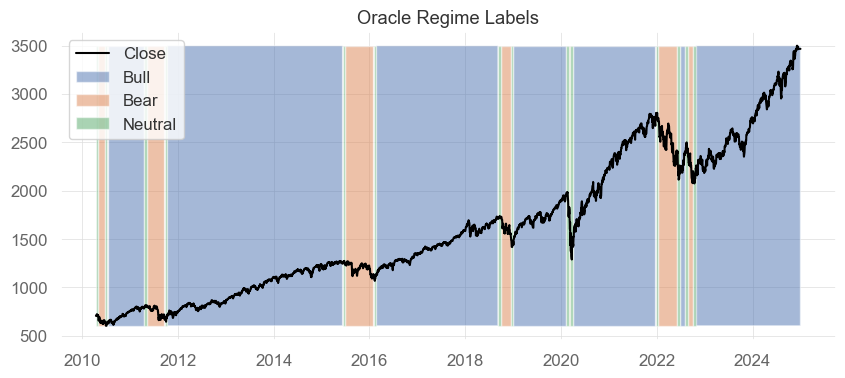

In [68]:
plot_regimes(df_final, regime_col='Oracle', title='Oracle Regime Labels')

In [69]:
df_final

,Close,High,Low,Open,Volume,daily_return,daily_volatility,ewma_return_20,ewma_return_50,daily_range,...,s&p_ewma_20,s&p_ewma_50,Ticker_x,short_term_index,Ticker_y,uncertainity,etf_daily_return_ishares,etf_daily_return_van,regime,Oracle
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-16,705.239990,716.359985,701.849976,716.359985,0.0,-0.015523,0.006623,0.001236,0.002237,14.510010,...,0.000931,0.001771,__NTRIND,2.99,PUWLEMUINDXD,74.00,-0.015202,0.000000,Neutral,0.0
2010-04-19,707.190002,707.710022,699.010010,705.229981,0.0,0.002765,0.006396,0.001382,0.002258,8.700012,...,0.001275,0.001880,__NTRIND,0.61,PUWLEMUINDXD,49.01,0.001841,0.000000,Neutral,0.0
2010-04-20,713.619995,714.020019,707.190002,707.190002,0.0,0.009092,0.006528,0.002116,0.002526,6.830017,...,0.001922,0.002122,__NTRIND,0.96,PUWLEMUINDXD,57.51,0.009895,0.000000,Neutral,0.0
2010-04-21,713.549988,715.840027,709.270019,713.609985,0.0,-0.000098,0.006396,0.001905,0.002423,6.570007,...,0.001643,0.002000,__NTRIND,1.78,PUWLEMUINDXD,5.88,-0.000139,0.000000,Neutral,0.0
2010-04-22,716.229981,717.059998,704.179993,713.520019,0.0,0.003756,0.006174,0.002082,0.002475,12.880005,...,0.001706,0.002012,__NTRIND,1.31,PUWLEMUINDXD,4.90,0.003360,0.000000,Neutral,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,0.000824,0.000823,__NTRIND,0.70,PUWLEMUINDXD,20.61,0.010256,0.012225,Bull,1.0
2024-12-26,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,0.000714,0.000778,__NTRIND,1.01,PUWLEMUINDXD,25.51,0.001021,0.000713,Bull,1.0
2024-12-27,3466.199951,3481.860107,3457.320068,3468.979980,0.0,-0.000631,0.005514,0.000528,0.001031,24.540039,...,-0.000399,0.000318,__NTRIND,1.08,PUWLEMUINDXD,63.13,-0.011424,-0.010907,Bull,1.0


In [70]:
base_features = [
    'daily_volatility', 'ewma_return_50', 'ewma_return_20','put_call_ratio',
    'momentum_14', 'atr_14', 'macd', 'macd_signal',
    'bollinger_upper','bollinger_lower','s&p_index','dpo'
]
# macro_features = [ 'US3MBill']
xgb_features = base_features

In [71]:
unique_oracle = sorted(df_final['Oracle'].unique())
label_map = {label: idx for idx, label in enumerate(unique_oracle)}
inv_label_map = {v: k for k, v in label_map.items()}

In [72]:
param_dist = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__gamma': [0, 0.1],
    'xgb__reg_alpha': [0.1, 1.0],
    'xgb__reg_lambda': [1.0, 2.0]
}

Text(0.5, 1.0, 'Technical Feature Correlations')

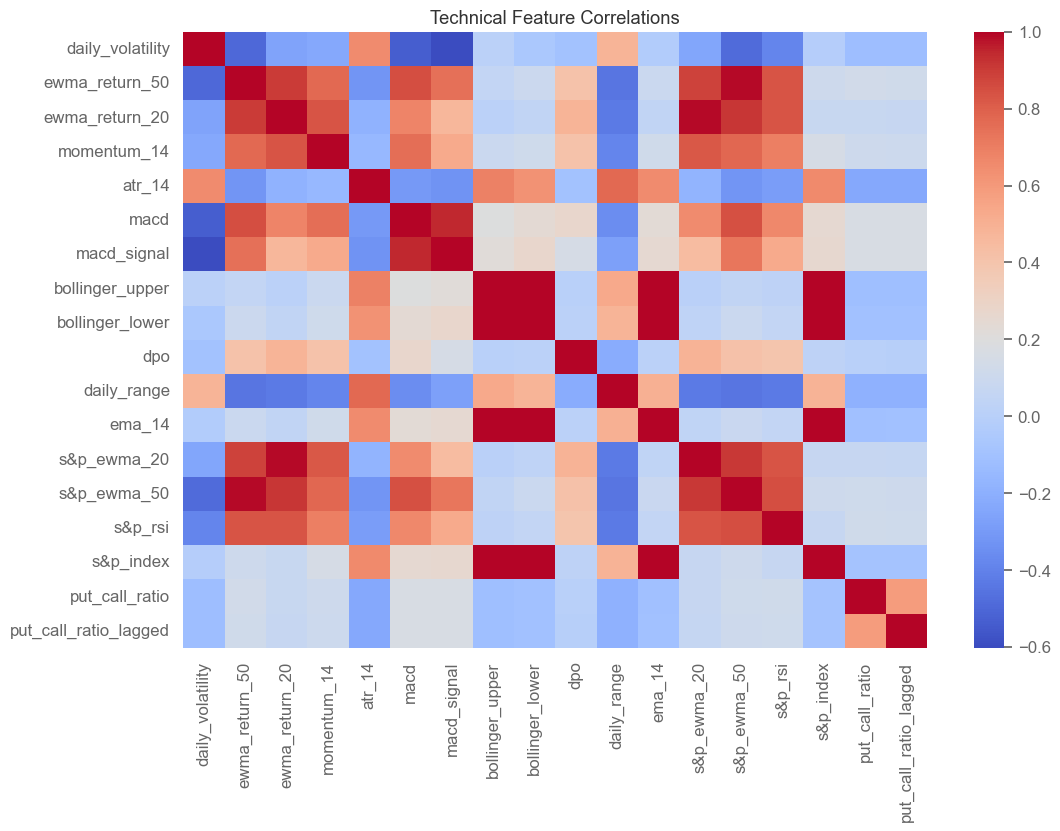

In [73]:
technical = ['daily_volatility', 'ewma_return_50', 'ewma_return_20',
    'momentum_14', 'atr_14', 'macd', 'macd_signal',
    'bollinger_upper','bollinger_lower','dpo','daily_range','ema_14','s&p_ewma_20','s&p_ewma_50','s&p_rsi','s&p_index','put_call_ratio','put_call_ratio_lagged']
corr_matrix = df_final[technical].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Technical Feature Correlations')

Text(0.5, 1.0, 'Macro Feature Correlations')

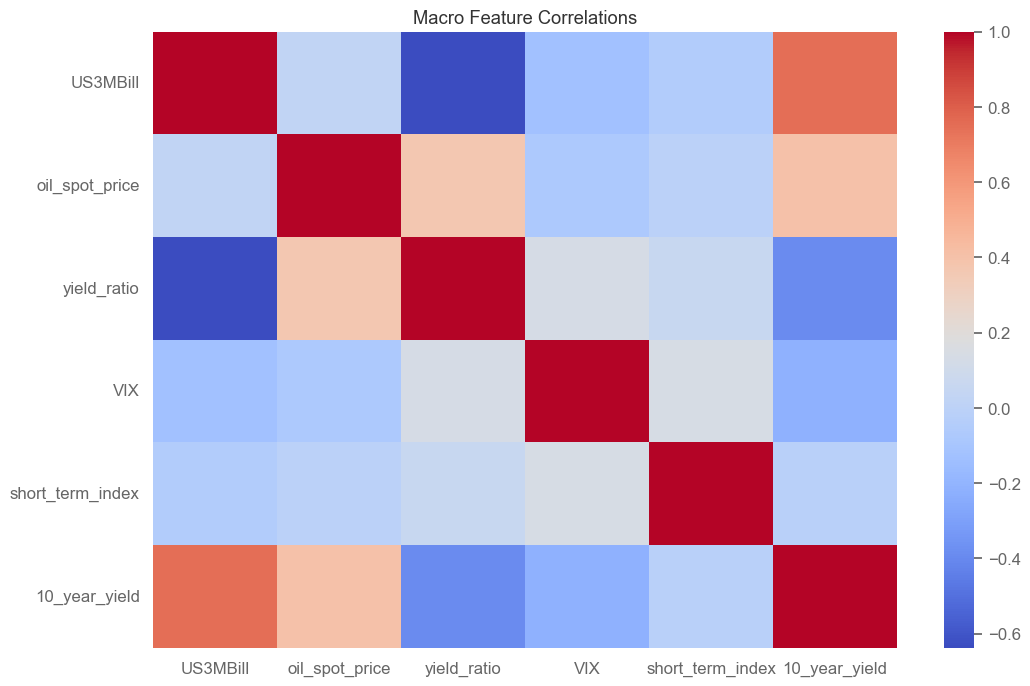

In [74]:
macro = ['US3MBill','oil_spot_price','yield_ratio','VIX','short_term_index','10_year_yield']
corr_matrix = df_final[macro].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Macro Feature Correlations')

In [75]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logging.info("Starting robust walk-forward validation...")

# Initialize column for out-of-sample predictions
df_final['XGB_regime'] = np.nan

tscv = TimeSeriesSplit(n_splits=2)  # Adjust splits as needed
results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_final)):
    # print(train_idx, test_idx)
    train_data = df_final.iloc[train_idx].copy()
    test_data = df_final.iloc[test_idx].copy()
    
    # Create fold-specific mapping based on unique classes in the training set.
    unique_classes_fold = sorted(train_data['Oracle'].unique())
    if len(unique_classes_fold) < 2:
        logging.warning(f"Skipping fold {fold+1}: not enough classes in training data - {unique_classes_fold}")
        continue
    label_map_fold = {label: idx for idx, label in enumerate(unique_classes_fold)}
    inv_label_map_fold = {idx: label for label, idx in label_map_fold.items()}
    
    # Use the fold-specific mapping
    X_train = train_data[xgb_features]
    y_train = train_data['Oracle'].map(label_map_fold)
    X_test = test_data[xgb_features]
    y_test = test_data['Oracle'].map(label_map_fold)
    
    # Check that training set has at least 2 classes
    unique_train_classes = np.unique(y_train)
    if len(unique_train_classes) < 2:
        logging.warning(f"Skipping fold {fold+1}: not enough classes in training data - {unique_train_classes}")
        continue
    
    # Build pipeline with StandardScaler and XGBoost classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=len(unique_train_classes),
            eval_metric='mlogloss',
            random_state=42
        ))
    ])
    
    search = RandomizedSearchCV(
        pipeline,
        param_dist,  # ensure param_dist is defined correctly
        n_iter=100,
        scoring='balanced_accuracy',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1,
        random_state=42,
        error_score='raise'
    )
    
    search.fit(X_train, y_train)
    preds = search.predict(X_test)
    
    # Map predictions back to original regime values and assign to df_final
    df_final.loc[test_data.index, 'XGB_regime'] = [inv_label_map_fold[p] for p in preds]
    
    test_acc = balanced_accuracy_score(y_test, preds)
    test_data = test_data.assign(XGB_regime=[inv_label_map_fold[p] for p in preds])
    returns_ishares = regime_to_portfolio_returns(test_data,'etf_daily_return_ishares' ,regime_col='XGB_regime')
    returns_van = regime_to_portfolio_returns(test_data,'etf_daily_return_van' ,regime_col='XGB_regime')

    
    results.append({
        'fold': fold+1,
        'train_start': train_data.index[0],
        'train_end': train_data.index[-1],
        'test_start': test_data.index[0],
        'test_end': test_data.index[-1],
        'accuracy': test_acc,
        'best_params': search.best_params_,
        'metrics_ishares': compute_quantstats_metrics(returns_ishares),
        'metrics_van': compute_quantstats_metrics(returns_van),
    })
    print(results[-1])
    logging.info(f"Fold {fold+1} completed: Accuracy={test_acc:.4f}")
    logging.info(classification_report(y_test, preds, target_names=[f"class_{c}" for c in unique_classes_fold]))


logging.info("Process completed successfully!")

{'fold': 1, 'train_start': Timestamp('2010-04-16 00:00:00'), 'train_end': Timestamp('2015-03-12 00:00:00'), 'test_start': Timestamp('2015-03-13 00:00:00'), 'test_end': Timestamp('2020-02-05 00:00:00'), 'accuracy': 0.3333333333333333, 'best_params': {'xgb__reg_lambda': 2.0, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0}, 'metrics_ishares': {'Annualized Return (%)': 8.017034078741325, 'Cumulative Return (%)': 72.94232270494953, 'Annualized Risk (%)': 13.495421203079704, 'Max Drawdown (%)': -24.33083342585405, 'Ulcer Index (%)': 5.318651256245131, 'Sharpe Ratio': 0.8675375502319398, 'Sortino Ratio': 1.1967142321705537, 'Calmar Ratio': 0.32950100551107264, 'Gain/Pain Ratio': 0.17228307784838642, 'Win Rate (%)': 54.85398579321231, 'Profit Factor': 1.1722830778483864}, 'metrics_van': {'Annualized Return (%)': 8.443614119356035, 'Cumulative Return (%)': 77.85252596899916, 'Annualized Risk (%)': 13.205250436707752, 'Max Drawdow

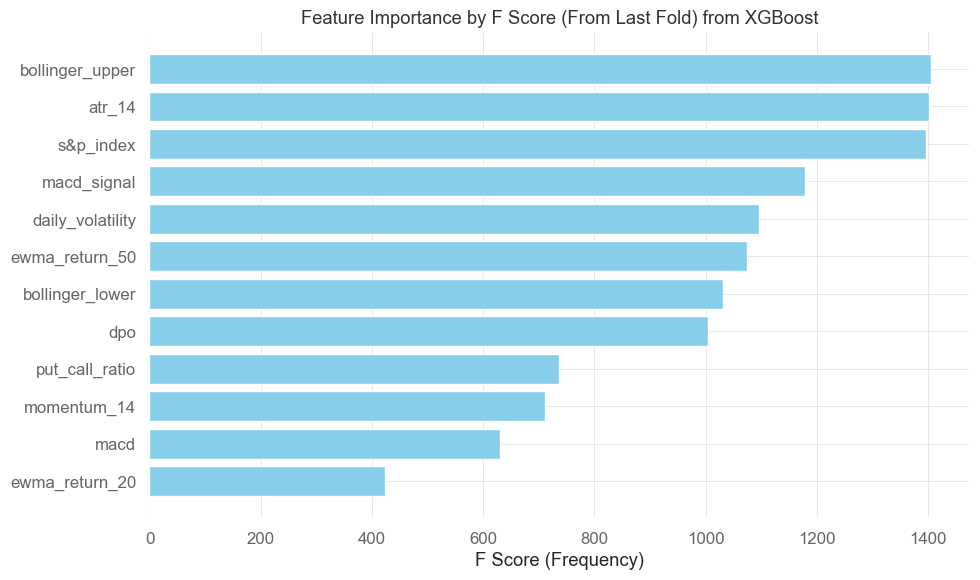

Feature F Scores:
ewma_return_20: 424.0
macd: 631.0
momentum_14: 711.0
put_call_ratio: 736.0
dpo: 1004.0
bollinger_lower: 1032.0
ewma_return_50: 1074.0
daily_volatility: 1097.0
macd_signal: 1179.0
s&p_index: 1396.0
atr_14: 1402.0
bollinger_upper: 1406.0


In [76]:
booster = search.best_estimator_.named_steps['xgb'].get_booster()
fscore = booster.get_score(importance_type='weight')
mapped_fscore = {}
for key, score in fscore.items():
    if key.startswith('f') and key[1:].isdigit():
        idx = int(key[1:])
        if idx < len(xgb_features):
            mapped_fscore[xgb_features[idx]] = score
        else:
            mapped_fscore[key] = score
    else:
        mapped_fscore[key] = score

fscore_df = pd.DataFrame(list(mapped_fscore.items()), columns=['Feature', 'F Score'])
fscore_df = fscore_df.sort_values(by='F Score', ascending=True)


plt.figure(figsize=(10, 6))
plt.barh(fscore_df['Feature'], fscore_df['F Score'], color='skyblue')
plt.xlabel("F Score (Frequency)")
plt.title("Feature Importance by F Score (From Last Fold) from XGBoost")
plt.tight_layout()
plt.show()


print("Feature F Scores:")
for index, row in fscore_df.iterrows():
    print(f"{row['Feature']}: {row['F Score']}")

In [77]:
features_for_hmm = [
                    'daily_range', 'daily_volatility','oil_spot_price','yield_ratio','US3MBill','VIX','put_call_ratio',
                    'put_call_ratio_lagged','ewma_return_50','ewma_return_20','macd_signal','macd','short_term_index','10_year_yield','s&p_ewma_20','s&p_ewma_50','s&p_rsi','ema_14'
                    ]

In [78]:
def map_hmm_states(y_true, y_pred):

    labels_true = np.unique(y_true)
    labels_pred = np.unique(y_pred)
    cost_matrix = np.zeros((len(labels_pred), len(labels_true)))
    
    for i, pred in enumerate(labels_pred):
        for j, true in enumerate(labels_true):
            cost_matrix[i, j] = -np.sum((y_pred == pred) & (y_true == true))
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {labels_pred[i]: labels_true[j] for i, j in zip(row_ind, col_ind)}
    return mapping

Fold 1 Metrics:
{'fold': 1, 'test_start': Timestamp('2015-03-13 00:00:00'), 'test_end': Timestamp('2020-02-05 00:00:00'), 'metrics_ishares': {'Annualized Return (%)': 8.640152715769943, 'Cumulative Return (%)': 80.15481078970754, 'Annualized Risk (%)': 13.49255736135793, 'Max Drawdown (%)': -24.33083342585407, 'Ulcer Index (%)': 5.713430961669509, 'Sharpe Ratio': 0.9272779334923061, 'Sortino Ratio': 1.3140558699088574, 'Calmar Ratio': 0.35511125182374037, 'Gain/Pain Ratio': 0.18520274191749306, 'Win Rate (%)': 55.327545382794, 'Profit Factor': 1.185202741917493}, 'metrics_van': {'Annualized Return (%)': 8.883744346109012, 'Cumulative Return (%)': 83.04378094248521, 'Annualized Risk (%)': 13.203126306523183, 'Max Drawdown (%)': -24.162811442649833, 'Ulcer Index (%)': 5.639584064425043, 'Sharpe Ratio': 0.9684208118987732, 'Sortino Ratio': 1.3840588328275272, 'Calmar Ratio': 0.3676618661364999, 'Gain/Pain Ratio': 0.19224111111802897, 'Win Rate (%)': 53.743104806934596, 'Profit Factor': 1.

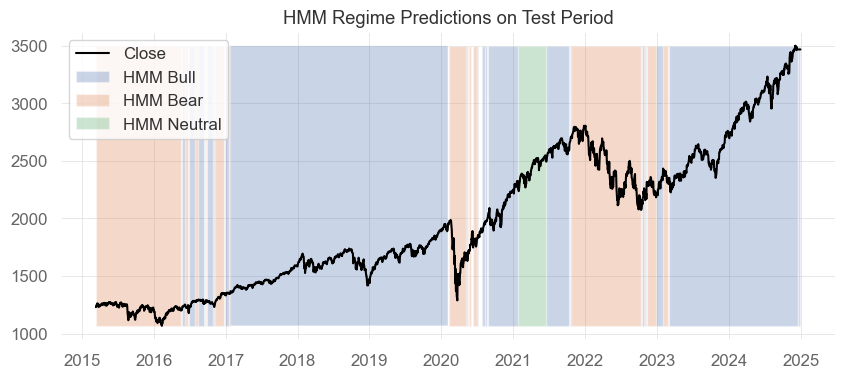

In [79]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logging.info("Starting HMM walk-forward validation...")

# Initialize a new column for HMM predictions.
df_final['HMM_regime'] = np.nan

tscv = TimeSeriesSplit(n_splits=2) 
hmm_results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_final)):
    logging.info(f"Processing fold {fold+1}...")
    train_data = df_final.iloc[train_idx].copy()
    test_data = df_final.iloc[test_idx].copy()
    
    # Ensure we have enough data in the selected features (drop NaNs)
    train_features = train_data[features_for_hmm].dropna()
    test_features = test_data[features_for_hmm].dropna()
    
    if len(train_features) == 0 or len(test_features) == 0:
        logging.warning(f"Fold {fold+1} skipped: insufficient data after dropping NaNs.")
        continue

    # --- Train the HMM on the training period ---
    hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
    hmm_model.fit(train_features)
    
  
    predicted_states = hmm_model.predict(test_features)
    oracle_labels = test_data.loc[test_features.index, 'Oracle'].values
    state_mapping = map_hmm_states(oracle_labels, predicted_states)
    mapped_states = np.array([state_mapping[state] for state in predicted_states])
    test_data.loc[test_features.index, 'HMM_regime'] = mapped_states
    

    hmm_returns_ishares = regime_to_portfolio_returns(test_data,'etf_daily_return_ishares', regime_col='HMM_regime', t_bills_col='US3MBill')
    hmm_returns_van = regime_to_portfolio_returns(test_data,'etf_daily_return_van', regime_col='HMM_regime', t_bills_col='US3MBill')
    metrics_ishares = compute_quantstats_metrics(hmm_returns_ishares)
    metrics_van = compute_quantstats_metrics(hmm_returns_van)
    
    hmm_results.append({
        'fold': fold+1,
        'test_start': test_data.index[0],
        'test_end': test_data.index[-1],
        'metrics_ishares': metrics_ishares,
        'metrics_van': metrics_van,
    })
    
    print(f"Fold {fold+1} Metrics:")
    print(hmm_results[-1])
    print(metrics_ishares)
    print(metrics_van)
    print("\n")
    
    df_final.loc[test_data.index, 'HMM_regime'] = test_data['HMM_regime']


logging.info("Training final HMM model on full dataset...")

full_features = df_final[features_for_hmm].dropna()
final_hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
final_hmm_model.fit(full_features)
final_predicted_states = final_hmm_model.predict(full_features)
oracle_full = df_final.loc[full_features.index, 'Oracle'].values
final_state_mapping = map_hmm_states(oracle_full, final_predicted_states)
final_mapped_states = np.array([final_state_mapping[state] for state in final_predicted_states])
df_final.loc[full_features.index, 'HMM_regime_final'] = final_mapped_states

df_test = df_final[df_final['HMM_regime'].notna()].copy()
hmm_test_returns_ishares = regime_to_portfolio_returns(df_test,'etf_daily_return_ishares', regime_col='HMM_regime', t_bills_col='US3MBill')
hmm_test_returns_van = regime_to_portfolio_returns(df_test, 'etf_daily_return_van',regime_col='HMM_regime', t_bills_col='US3MBill')
hmm_test_metrics_ishares = compute_quantstats_metrics(hmm_test_returns_ishares)
hmm_test_metrics_van = compute_quantstats_metrics(hmm_test_returns_van)


print("=== HMM Walk-Forward Test Performance ===")
print("Metrics:")
print(hmm_test_metrics_ishares)
print(hmm_test_metrics_van)


plt.figure(figsize=(10, 4))
plt.plot(df_test['Close'], label='Close', color='black')
plt.fill_between(df_test.index, df_test['Close'].min(), df_test['Close'].max(),
                 where=(df_test['HMM_regime'] == 1), alpha=0.3, label='HMM Bull')
plt.fill_between(df_test.index, df_test['Close'].min(), df_test['Close'].max(),
                 where=(df_test['HMM_regime'] == -1), alpha=0.3, label='HMM Bear')
plt.fill_between(df_test.index, df_test['Close'].min(), df_test['Close'].max(),
                 where=(df_test['HMM_regime'] == 0), alpha=0.3, label='HMM Neutral')
plt.title("HMM Regime Predictions on Test Period")
plt.legend()
plt.show()


In [80]:
def vote_regime(A, B):
    
    if A == B:
        return A
    elif (A == 0 and B != 0):
        return B
    elif (B == 0 and A != 0):
        return A
    else:
        return 0



In [81]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logging.info("Starting robust walk-forward validation for BaggingClassifier...")


df_final['BAG_regime'] = np.nan


tscv = TimeSeriesSplit(n_splits=2)  # Adjust splits as needed
bag_results = []

# Define parameter grid for BaggingClassifier with DecisionTreeClassifier as base estimator.
param_dist_bag = {
    'bag__n_estimators': [10, 20, 50],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0],
    # Parameters for the base estimator (DecisionTreeClassifier)
    'bag__estimator__max_depth': [None, 5, 10],
    'bag__estimator__min_samples_split': [2, 5, 10]
}

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_final)):
    train_data = df_final.iloc[train_idx].copy()
    test_data = df_final.iloc[test_idx].copy()
    
    # Create fold-specific mapping based on unique classes in the training set.
    unique_classes_fold = sorted(train_data['Oracle'].unique())
    if len(unique_classes_fold) < 2:
        logging.warning(f"Skipping fold {fold+1}: not enough classes in training data - {unique_classes_fold}")
        continue
    label_map_fold = {label: idx for idx, label in enumerate(unique_classes_fold)}
    inv_label_map_fold = {idx: label for label, idx in label_map_fold.items()}
    
    # Map xgb_features and target using the fold-specific mapping.
    X_train = train_data[xgb_features]
    y_train = train_data['Oracle'].map(label_map_fold)
    X_test = test_data[xgb_features]
    y_test = test_data['Oracle'].map(label_map_fold)
    
    unique_train_classes = np.unique(y_train)
    if len(unique_train_classes) < 2:
        logging.warning(f"Skipping fold {fold+1}: not enough classes in training data - {unique_train_classes}")
        continue
    
    # Build pipeline with StandardScaler and BaggingClassifier.
    # Here we use a DecisionTreeClassifier as the base estimator.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('bag', BaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=42),
            random_state=42
        ))
    ])
    
    search = RandomizedSearchCV(
        pipeline,
        param_dist_bag,
        n_iter=50,
        scoring='balanced_accuracy',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1,
        random_state=42,
        error_score='raise'
    )
    
    search.fit(X_train, y_train)
    preds = search.predict(X_test)
    
    # Map predictions back to original regime values and assign to df_final.
    df_final.loc[test_data.index, 'BAG_regime'] = [inv_label_map_fold[p] for p in preds]
    
    test_acc = balanced_accuracy_score(y_test, preds)
    test_data = test_data.assign(BAG_regime=[inv_label_map_fold[p] for p in preds])
    returns = regime_to_portfolio_returns(test_data,'etf_daily_return_ishares', regime_col='BAG_regime')
    
    bag_results.append({
        'fold': fold+1,
        'train_start': train_data.index[0],
        'train_end': train_data.index[-1],
        'test_start': test_data.index[0],
        'test_end': test_data.index[-1],
        'accuracy': test_acc,
        'best_params': search.best_params_,
        'metrics': compute_quantstats_metrics(returns)
    })
    print(bag_results[-1])
    logging.info(f"Fold {fold+1} completed: Accuracy={test_acc:.4f}, ")
    logging.info(classification_report(y_test, preds, target_names=[f"class_{c}" for c in unique_classes_fold]))

#############################################################################
# Final Model Training on Full Data for BaggingClassifier
#############################################################################
unique_oracle = sorted(df_final['Oracle'].unique())
label_map_global = {label: idx for idx, label in enumerate(unique_oracle)}
inv_label_map_global = {idx: label for label, idx in label_map_global.items()}

logging.info("Training final BaggingClassifier model on full dataset...")
final_bag_model = search.best_estimator_.fit(df_final[xgb_features], df_final['Oracle'].map(label_map_global))
df_final['BAG_regime_final'] = np.vectorize(inv_label_map_global.get)(final_bag_model.predict(df_final[xgb_features]))


# Compute average feature importance from base estimators in the bagging ensemble.
base_importances = []
for estimator in final_bag_model.named_steps['bag'].estimators_:
    # Some base estimators might not support feature_importances_; we check before appending.
    if hasattr(estimator, "feature_importances_"):
        base_importances.append(estimator.feature_importances_)
if base_importances:
    avg_importances = np.mean(base_importances, axis=0)
else:
    avg_importances = np.zeros(len(xgb_features))

plt.figure(figsize=(10, 6))
# plt.bar(range(len(xgb_features)), avg_importances)
plt.xticks(range(len(xgb_features)), xgb_features, rotation=45, ha="right")
plt.title("BaggingClassifier (Decision Trees) Average Feature Importance")
plt.tight_layout()
plt.close()


logging.info("BaggingClassifier process completed successfully!")


{'fold': 1, 'train_start': Timestamp('2010-04-16 00:00:00'), 'train_end': Timestamp('2015-03-12 00:00:00'), 'test_start': Timestamp('2015-03-13 00:00:00'), 'test_end': Timestamp('2020-02-05 00:00:00'), 'accuracy': 0.3333333333333333, 'best_params': {'bag__n_estimators': 50, 'bag__max_samples': 0.5, 'bag__max_features': 1.0, 'bag__estimator__min_samples_split': 10, 'bag__estimator__max_depth': 5}, 'metrics': {'Annualized Return (%)': 8.017034078741325, 'Cumulative Return (%)': 72.94232270494953, 'Annualized Risk (%)': 13.495421203079704, 'Max Drawdown (%)': -24.33083342585405, 'Ulcer Index (%)': 5.318651256245131, 'Sharpe Ratio': 0.8675375502319398, 'Sortino Ratio': 1.1967142321705537, 'Calmar Ratio': 0.32950100551107264, 'Gain/Pain Ratio': 0.17228307784838642, 'Win Rate (%)': 54.85398579321231, 'Profit Factor': 1.1722830778483864}}
{'fold': 2, 'train_start': Timestamp('2010-04-16 00:00:00'), 'train_end': Timestamp('2020-02-05 00:00:00'), 'test_start': Timestamp('2020-02-06 00:00:00'), 

All Feature Importances (averaged across base estimators, ascending order):
put_call_ratio: 0.0660
momentum_14: 0.0686
macd_signal: 0.1002
ewma_return_20: 0.1037
dpo: 0.1226
bollinger_lower: 0.1663
daily_volatility: 0.1799
atr_14: 0.1870
s&p_index: 0.2008
bollinger_upper: 0.2161
macd: 0.2435
ewma_return_50: 0.3545


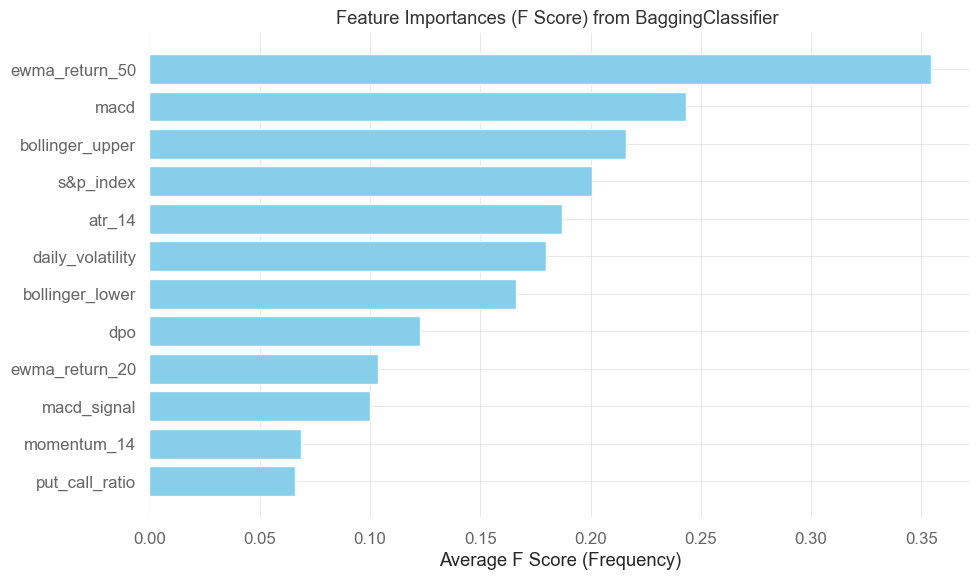

In [82]:
n_features = len(xgb_features)
importance_sum = np.zeros(n_features)
importance_counts = np.zeros(n_features)

for est, feat_idx in zip(final_bag_model.named_steps['bag'].estimators_,
                           final_bag_model.named_steps['bag'].estimators_features_):
    
    fi = est.feature_importances_
    for idx, imp in zip(feat_idx, fi):
        importance_sum[idx] += imp
        importance_counts[idx] += 1

# Compute the average importance for each feature. For features never selected, the importance remains 0.
avg_importances = np.divide(importance_sum, importance_counts, out=np.zeros_like(importance_sum), where=importance_counts != 0)

# Create a DataFrame with feature names and average importances.
df_importance = pd.DataFrame({
    'Feature': xgb_features,
    'Avg Importance': avg_importances
})

# Sort the DataFrame in ascending order by importance.
df_importance_sorted = df_importance.sort_values(by='Avg Importance', ascending=True)

# Print out the sorted feature importances.
print("All Feature Importances (averaged across base estimators, ascending order):")
for index, row in df_importance_sorted.iterrows():
    print(f"{row['Feature']}: {row['Avg Importance']:.4f}")

# Create a horizontal bar plot for the sorted feature importances.
plt.figure(figsize=(10, 6))
plt.barh(df_importance_sorted['Feature'], df_importance_sorted['Avg Importance'], color='skyblue')
plt.xlabel("Average F Score (Frequency)")
plt.title("Feature Importances (F Score) from BaggingClassifier ")
plt.tight_layout()
plt.show()


In [83]:
test1 = test2_start_date
test2 = last_date

df_test = df_final[(df_final['XGB_regime'].notna() & df_final['HMM_regime'].notna()) & df_final['BAG_regime'].notna()].copy()
df_test = df_test[(df_test.index >= test1) & (df_test.index < test2)]
df_test['Vote_regime_XH'] = df_test.apply(lambda row: vote_regime(row['HMM_regime'], row['XGB_regime']), axis=1)
df_test['Vote_regime_BH'] = df_test.apply(lambda row: vote_regime(row['BAG_regime'], row['HMM_regime']), axis=1)
oracle_returns_ishares = regime_to_portfolio_returns(df_test,'etf_daily_return_ishares', regime_col='Oracle', t_bills_col='US3MBill')
xgb_returns_ishares = regime_to_portfolio_returns(df_test,'etf_daily_return_ishares', regime_col='XGB_regime', t_bills_col='US3MBill')
hmm_returns_ishares = regime_to_portfolio_returns(df_test,'etf_daily_return_ishares', regime_col='HMM_regime', t_bills_col='US3MBill')
vote_xh_returns_ishares = regime_to_portfolio_returns(df_test,'etf_daily_return_ishares', regime_col='Vote_regime_XH', t_bills_col='US3MBill')
bagging_returns_ishares = regime_to_portfolio_returns(df_test,'etf_daily_return_ishares', regime_col='BAG_regime', t_bills_col='US3MBill')
vote_bh_returns_ishares = regime_to_portfolio_returns(df_test,'etf_daily_return_ishares', regime_col='Vote_regime_BH', t_bills_col='US3MBill')

oracle_returns_van = regime_to_portfolio_returns(df_test,'etf_daily_return_van', regime_col='Oracle', t_bills_col='US3MBill')
xgb_returns_van = regime_to_portfolio_returns(df_test,'etf_daily_return_van' ,regime_col='XGB_regime', t_bills_col='US3MBill')
hmm_returns_van = regime_to_portfolio_returns(df_test,'etf_daily_return_van', regime_col='HMM_regime', t_bills_col='US3MBill')
vote_xh_returns_van = regime_to_portfolio_returns(df_test,'etf_daily_return_van', regime_col='Vote_regime_XH', t_bills_col='US3MBill')
bagging_returns_van = regime_to_portfolio_returns(df_test,'etf_daily_return_van', regime_col='BAG_regime', t_bills_col='US3MBill')
vote_bh_returns_van = regime_to_portfolio_returns(df_test,'etf_daily_return_van', regime_col='Vote_regime_BH', t_bills_col='US3MBill')

buy_hold_returns_ishares = df_test['etf_daily_return_ishares']
buy_hold_returns_van = df_test['etf_daily_return_van']

oracle_metrics_ishares = compute_quantstats_metrics(oracle_returns_ishares)
oracle_metrics_van = compute_quantstats_metrics(oracle_returns_van)
xgb_metrics_van = compute_quantstats_metrics(xgb_returns_van)
xgb_metrics_ishares = compute_quantstats_metrics(xgb_returns_ishares)
hmm_metrics_van = compute_quantstats_metrics(hmm_returns_van)
hmm_metrics_ishares = compute_quantstats_metrics(hmm_returns_ishares)
buy_hold_metrics_ishares = compute_quantstats_metrics(buy_hold_returns_ishares)
buy_hold_metrics_van = compute_quantstats_metrics(buy_hold_returns_van)
bag_returns_ishares= compute_quantstats_metrics(bagging_returns_ishares)
bag_returns_van = compute_quantstats_metrics(bagging_returns_van)
vote_xh_metrics_ishares = compute_quantstats_metrics(vote_xh_returns_ishares)
vote_xh_metrics_van = compute_quantstats_metrics(vote_xh_returns_van)
vote_bh_metrics_ishares = compute_quantstats_metrics(vote_bh_returns_ishares)
vote_bh_metrics_van = compute_quantstats_metrics(vote_bh_returns_van)


print("Performance Metrics (Test Set) Ishares:")
print("Tested from:",test1, " to ",test2)
print("Oracle:", oracle_metrics_ishares)
print("Buy & Hold:", buy_hold_metrics_ishares)
print("XGBoost:", xgb_metrics_ishares)
print("HMM:", hmm_metrics_ishares)
print("Vote_XH:", vote_xh_metrics_ishares)
print("Bagging:", bag_returns_ishares)
print("Vote_BH:", vote_bh_metrics_ishares)

print("Performance Metrics (Test Set) Van:")
print("Oracle:", oracle_metrics_van)
print("Buy & Hold:", buy_hold_metrics_van)
print("XGBoost:", xgb_metrics_van)
print("HMM:", hmm_metrics_van)
print("Vote_XH:", vote_xh_metrics_van)
print("Bagging:", bag_returns_van)
print("Vote_BH:", vote_bh_metrics_van)



Performance Metrics (Test Set) Ishares:
Tested from: 2020-02-01 00:00:00  to  2025-01-01
Oracle: {'Annualized Return (%)': 25.214178752224093, 'Cumulative Return (%)': 395.23629955290903, 'Annualized Risk (%)': 17.652728407423872, 'Max Drawdown (%)': -11.076389923513364, 'Ulcer Index (%)': 3.2920152568749925, 'Sharpe Ratio': 1.8705393729061959, 'Sortino Ratio': 2.909764672913536, 'Calmar Ratio': 2.276389593210195, 'Gain/Pain Ratio': 0.4068968075425351, 'Win Rate (%)': 59.53125, 'Profit Factor': 1.406896807542535}
Buy & Hold: {'Annualized Return (%)': 11.302867093527702, 'Cumulative Return (%)': 114.23793957850404, 'Annualized Risk (%)': 21.692970299339613, 'Max Drawdown (%)': -35.219297332925734, 'Ulcer Index (%)': 9.301653878011987, 'Sharpe Ratio': 0.7996653168081176, 'Sortino Ratio': 1.1197801179422076, 'Calmar Ratio': 0.3209282396148461, 'Gain/Pain Ratio': 0.165174845881071, 'Win Rate (%)': 54.87900078064013, 'Profit Factor': 1.1651748458810711}
XGBoost: {'Annualized Return (%)': 21

Kuiper's Score:
Oracle: 1.0
XGBoost: 0.47917514584181253
HMM: 0.044316318267228816
Bagging: 0.23817663817663826
Vote XH 0.39680911680911685
Vote BH 0.28498053850166527


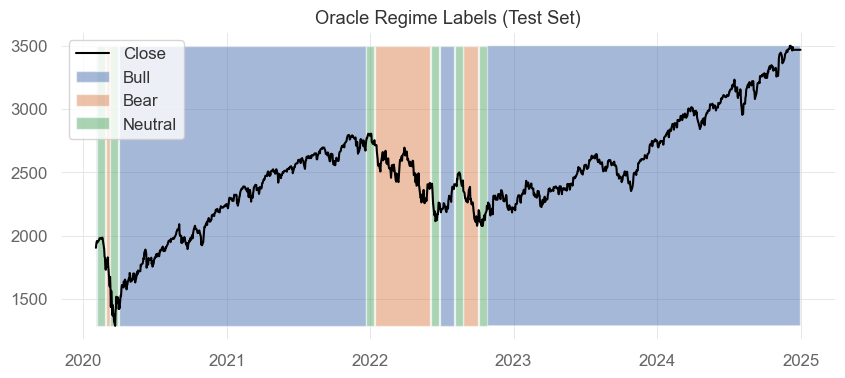

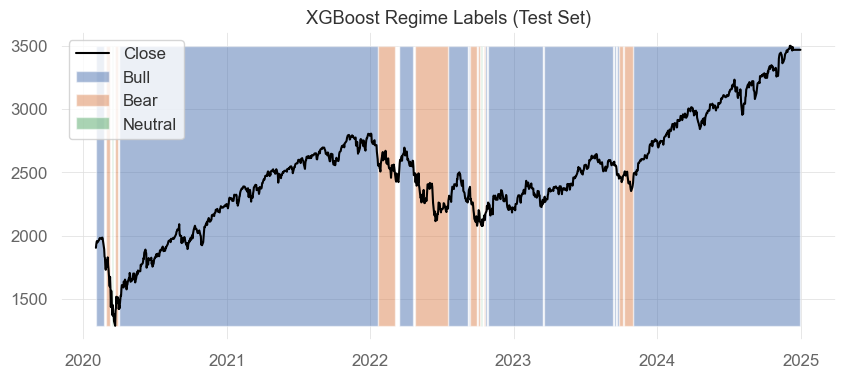

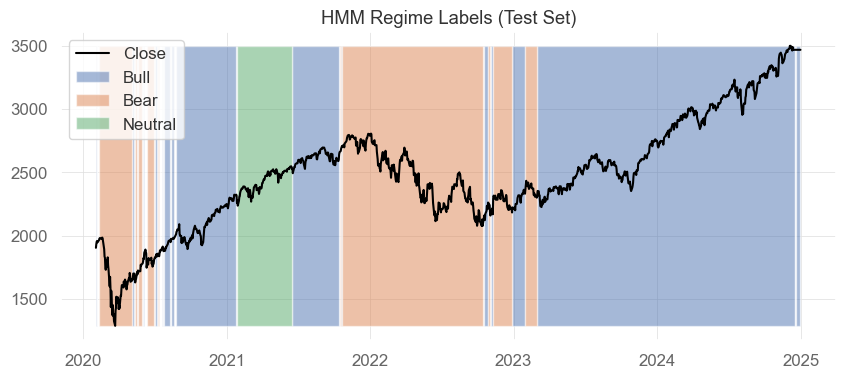

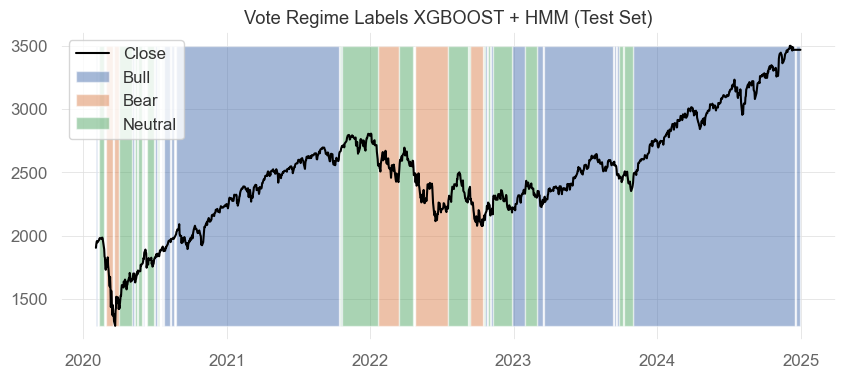

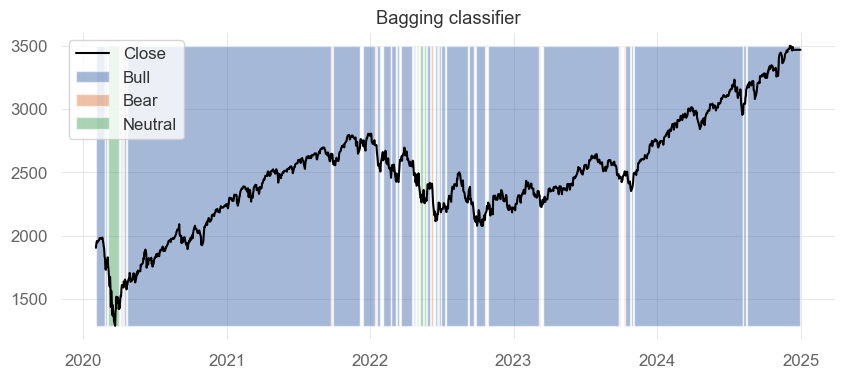

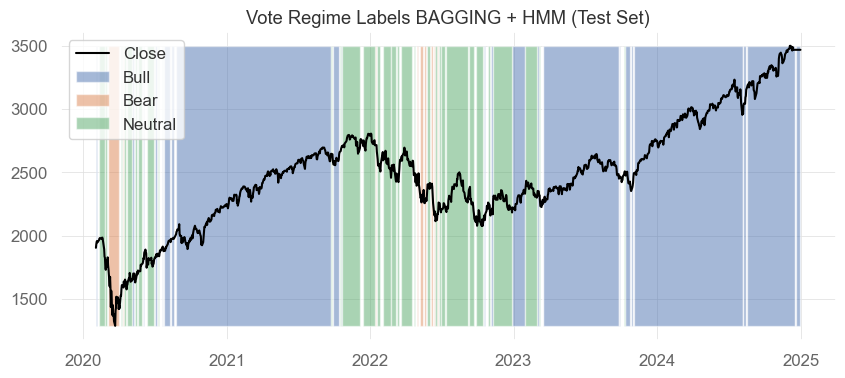

Oracle Proportions {'Bull %': '82.14%', 'Neutral %': '7.02%', 'Bear %': '10.84%'}
XGB Proportions {'Bull %': '85.73%', 'Neutral %': '1.17%', 'Bear %': '13.10%'}
HMM Proportions {'Bull %': '59.20%', 'Neutral %': '7.96%', 'Bear %': '32.84%'}
Bag Proportions {'Bull %': '92.82%', 'Neutral %': '3.67%', 'Bear %': '3.51%'}
Vote_XH Proportions {'Bull %': '64.59%', 'Neutral %': '23.71%', 'Bear %': '11.70%'}
Vote_BH Proportions {'Bull %': '65.52%', 'Neutral %': '28.94%', 'Bear %': '5.54%'}


In [84]:
ks_oracle = kuipers_score(df_test['Oracle'], df_test['Oracle'])
ks_xgb = kuipers_score(df_test['Oracle'], df_test['XGB_regime'])
ks_hmm = kuipers_score(df_test['Oracle'], df_test['HMM_regime'])
ks_bag = kuipers_score(df_test['Oracle'], df_test['BAG_regime'])
ks_vote_xh = kuipers_score(df_test['Oracle'], df_test['Vote_regime_XH'])
ks_vote_bh = kuipers_score(df_test['Oracle'], df_test['Vote_regime_BH'])

print("Kuiper's Score:")
print("Oracle:", ks_oracle)
print("XGBoost:", ks_xgb)
print("HMM:", ks_hmm)
print("Bagging:", ks_bag)
print("Vote XH",ks_vote_xh)
print("Vote BH",ks_vote_bh)

plot_regimes(df_test, regime_col='Oracle', title='Oracle Regime Labels (Test Set)')
plot_regimes(df_test, regime_col='XGB_regime', title='XGBoost Regime Labels (Test Set)')
plot_regimes(df_test, regime_col='HMM_regime', title='HMM Regime Labels (Test Set)')
plot_regimes(df_test, regime_col='Vote_regime_XH', title='Vote Regime Labels XGBOOST + HMM (Test Set)')
plot_regimes(df_test, regime_col='BAG_regime', title='Bagging classifier')
plot_regimes(df_test, regime_col='Vote_regime_BH', title='Vote Regime Labels BAGGING + HMM (Test Set)')


print("Oracle Proportions", state_proportions(df_test['Oracle'].values))
print("XGB Proportions", state_proportions(df_test['XGB_regime'].values))
print("HMM Proportions", state_proportions(df_test['HMM_regime'].values))
print("Bag Proportions", state_proportions(df_test['BAG_regime'].values))
print("Vote_XH Proportions", state_proportions(df_test['Vote_regime_XH'].values))
print("Vote_BH Proportions", state_proportions(df_test['Vote_regime_BH'].values))


In [85]:
df_test['BuyHold_Returns_ishares'] = buy_hold_returns_ishares
df_test['Oracle_Returns_ishares'] = oracle_returns_ishares
df_test['XGB_Returns_ishares'] = xgb_returns_ishares
df_test['HMM_Returns_ishares'] = hmm_returns_ishares
df_test["Vote_XH_Returns_ishares"] = vote_xh_returns_ishares
df_test["Vote_BH_Returns_ishares"] = vote_bh_returns_ishares
df_test['Bagging_Returns_ishares'] = bagging_returns_ishares

df_test['BuyHold_Returns_van'] = buy_hold_returns_van
df_test['Oracle_Returns_van'] = oracle_returns_van
df_test['XGB_Returns_van'] = xgb_returns_van
df_test['HMM_Returns_van'] = hmm_returns_van
df_test["Vote_XH_Returns_van"] = vote_xh_returns_van
df_test["Vote_BH_Returns_van"] = vote_bh_returns_van
df_test['Bagging_Returns_van'] = bagging_returns_van

strategy_map_ishares = {
    'Buy and Hold Strategy': 'BuyHold_Returns_ishares',
    'Oracle': 'Oracle_Returns_ishares',
    'XGBoost': 'XGB_Returns_ishares',
    'HMM': 'HMM_Returns_ishares',
    'Vote_XH': 'Vote_XH_Returns_ishares',
    'Bagging': 'Bagging_Returns_ishares',
    'Vote_BH': 'Vote_BH_Returns_ishares',
}

strategy_map_van = {
    'Buy and Hold Strategy': 'BuyHold_Returns_van',
    'Oracle': 'Oracle_Returns_van',
    'XGBoost': 'XGB_Returns_van',
    'HMM': 'HMM_Returns_van',
    'Vote_XH': 'Vote_XH_Returns_van',
    'Bagging': 'Bagging_Returns_van',
    'Vote_BH': 'Vote_BH_Returns_van',
}


In [86]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_model_metrics(name, oracle_metrics, buy_hold_metrics, xgb_metrics, hmm_metrics,
                                   vote_xh_metrics, bag_returns, vote_bh_metrics, strategy_map):
    
    metrics_data = {
        'Model': [ 'Buy & Hold','Bagging','Vote_BH','HMM','XGBoost','Vote_XH','Oracle' ],
        'Sharpe': [
            buy_hold_metrics['Sharpe Ratio'], 
            bag_returns['Sharpe Ratio'],
            vote_bh_metrics['Sharpe Ratio'],
            hmm_metrics['Sharpe Ratio'],
            xgb_metrics['Sharpe Ratio'], 
            vote_xh_metrics['Sharpe Ratio'],
            oracle_metrics['Sharpe Ratio'], 
        ],
        'Max Drawdown': [
            buy_hold_metrics['Max Drawdown (%)'], 
            bag_returns['Max Drawdown (%)'],
            vote_bh_metrics['Max Drawdown (%)'],
            hmm_metrics['Max Drawdown (%)'],
            xgb_metrics['Max Drawdown (%)'], 
            vote_xh_metrics['Max Drawdown (%)'],
            oracle_metrics['Max Drawdown (%)'], 
        ],
        'Annualized Return': [
            buy_hold_metrics['Annualized Return (%)'], 
            bag_returns['Annualized Return (%)'],
            vote_bh_metrics['Annualized Return (%)'],
            hmm_metrics['Annualized Return (%)'],
            xgb_metrics['Annualized Return (%)'], 
            vote_xh_metrics['Annualized Return (%)'],
            oracle_metrics['Annualized Return (%)'], 
        ],
        'Annualized Risk': [
            buy_hold_metrics['Annualized Risk (%)'], 
            bag_returns['Annualized Risk (%)'],
            vote_bh_metrics['Annualized Risk (%)'],
            hmm_metrics['Annualized Risk (%)'],
            xgb_metrics['Annualized Risk (%)'], 
            vote_xh_metrics['Annualized Risk (%)'],
            oracle_metrics['Annualized Risk (%)'], 
        ],
        "Kuiper's Score": [
            ks_oracle,  
            np.nan, 
            ks_xgb,
            ks_hmm,
            ks_vote_xh,
            ks_bag,
            ks_vote_bh
        ]
    }
    
    metrics_df = pd.DataFrame(metrics_data)
    
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Annualized Sharpe Ratio", "Annualized Risk", "Annualized Return", "Max Drawdown")
    )
    
    
    sorted_df = metrics_df
    fig.add_trace(
        go.Bar(
            x=sorted_df['Model'],
            y=sorted_df['Sharpe'],
            text=[f'{val:.2f}' for val in sorted_df['Sharpe']],
            textposition='outside',
            textfont=dict(size=15),
            marker=dict(color='#1f77b4', line=dict(width=2)),
            width=0.5,  
        ),
        row=1, col=1
    )
    
    
    
    fig.add_trace(
        go.Bar(
            x=sorted_df['Model'],
            y=sorted_df['Annualized Risk'],
            text=[f'{val:.2f}%' for val in sorted_df['Annualized Risk']],
            textposition='outside',
            textfont=dict(size=20),
            marker=dict(color='#1f77b4', line=dict(width=2)),
            width=0.5,  
        ),
        row=1, col=2
    )
    
    
    
    fig.add_trace(
        go.Bar(
            x=sorted_df['Model'],
            y=sorted_df['Annualized Return'],
            text=[f'{val:.2f}%' for val in sorted_df['Annualized Return']],
            textposition='outside',
            textfont=dict(size=20),
            marker=dict(color='#1f77b4', line=dict(width=2)),
            width=0.5,  
        ),
        row=2, col=1
    )
    
    
    
    fig.add_trace(
        go.Bar(
            x=sorted_df['Model'],
            y=sorted_df['Max Drawdown'],
            text=[f'{val:.2f}%' for val in sorted_df['Max Drawdown']],
            textposition='outside',
            textfont=dict(size=20),
            marker=dict(color='#1f77b4', line=dict(width=2)),
            width=0.5,  
        ),
        row=2, col=2
    )
    
    
    fig.update_layout(
        title_text=f'Model Metrics Comparison ({name})',
        template='plotly_white',
        height=1000,
        width=1400,
        showlegend = False
    )
    
    fig.show()
 

visualize_model_metrics("iShares Russell 3000 ETF",
                        oracle_metrics_ishares, 
                        buy_hold_metrics_ishares, 
                        xgb_metrics_ishares, 
                        hmm_metrics_ishares,
                        vote_xh_metrics_ishares,
                        bag_returns_ishares,
                        vote_bh_metrics_ishares,
                        strategy_map=strategy_map_ishares)

In [87]:
visualize_model_metrics("Vanguard Russell 3000 Index Fund ETF",
                        oracle_metrics_van, 
                        buy_hold_metrics_van, 
                        xgb_metrics_van, 
                        hmm_metrics_van,
                        vote_xh_metrics_van,
                        bag_returns_van,
                        vote_bh_metrics_van,
                        strategy_map=strategy_map_van)

In [88]:
# tickers = ['IDGT', 'IEZ', 'IYZ','IYM','IEO','IHE','IYT','IAT','IHF','IAK','IAI','IYE','IYC','IDU','IYK','IYJ','IYG','ITB','IYH','IYF','IHI','IGM','IBB','ITA','IGV','SOXX','IYW']  
tickers = ['IYW','IGM','IYF','IYG','IAI','SOXX']  

In [89]:
start_date = pd.to_datetime('2020-01-01')
end_date =last_date
trading_days = 252       
risk_free_rate = 0 
n = len(tickers)     
lookback_window_days = 180

In [90]:
price_data = pd.read_csv("portfolio (1).csv")

In [91]:
price_data = price_data.set_index('Date')
price_data.index = pd.to_datetime(price_data.index)
price_data = price_data.loc[start_date:end_date]

In [92]:
price_data = price_data[tickers]
price_data


,IYW,IGM,IYF,IYG,IAI,SOXX
Date,,,,,,
2020-01-02,58.100998,40.337132,63.359657,46.737278,63.200378,81.486961
2020-01-03,57.521015,40.005367,63.002892,46.283504,62.844898,79.967194
2020-01-06,57.875858,40.263588,62.966293,46.112968,62.981609,79.134140
2020-01-07,57.897881,40.276665,62.540974,45.911980,63.145672,80.590363
2020-01-08,58.475414,40.618233,62.925148,46.313972,63.446472,80.517227
...,...,...,...,...,...,...
2024-12-24,165.275497,105.694359,111.698929,78.772766,146.296677,223.314545
2024-12-26,165.335464,105.714348,112.017868,78.952271,146.745193,223.244629
2024-12-27,162.876740,104.295097,111.180656,78.314026,145.429550,221.357040


In [93]:
def print_results(tickers, w, c, ret, risk_value):
  print ("Optimal portfolio")
  print ("----------------------")
  for s in range(len(tickers)):
      print (" Investment in {} : {}%".format(tickers[s],round(100*w[s],2)))
  print(f'Cash: {c}')
  print ("----------------------")
  return_percentages = ret * 100
  print (f"Exp ret = {return_percentages}%")
  print (f"Expected risk    = {risk_value}%")


def compute_linear_returns(close_prices):
  daily_returns = close_prices.pct_change().dropna(axis = 0)
  mean_returns = daily_returns.mean()
  covariance_matrix = daily_returns.cov().to_numpy()

  return daily_returns, mean_returns, covariance_matrix

def compute_log_returns(close_prices):
  log_returns = np.log(close_prices / close_prices.shift(1))
  log_returns = log_returns.dropna(axis = 0)

  mean_log_returns = log_returns.mean()
  covariance_matrix = log_returns.cov().to_numpy()

  return log_returns, mean_log_returns, covariance_matrix

def project_returns(closing_prices, investment_horizon):
  log_returns, mean_log_returns, log_covariance_matrix = compute_log_returns(closing_prices)
  period_log_returns = investment_horizon * mean_log_returns
  period_log_covariance_matrix = investment_horizon * log_covariance_matrix
  period_returns = np.exp(period_log_returns + 0.5 * np.diag(period_log_covariance_matrix)) - 1
  period_covariance_matrix = np.outer(period_returns + 1, period_returns + 1) * (np.exp(period_log_covariance_matrix)-1)
  return period_returns, period_covariance_matrix


def calculate_portfolio_returns(asset_prices, weights):
    weights = np.array(weights).flatten()
    portfolio_value =  asset_prices.dot(weights)
    portfolio_returns = portfolio_value.pct_change().dropna()

    return portfolio_returns

def realized_sharpe_ratio(portfolio_returns, risk_free_rate=0, investment_horizon=21):
    periods_per_year = 252 / investment_horizon
    excess_returns = portfolio_returns - risk_free_rate
    mean_excess = np.mean(excess_returns)
    std_excess = np.std(excess_returns)
    sharpe_ratio = mean_excess / std_excess * np.sqrt(periods_per_year)
    return sharpe_ratio

In [94]:
@dataclass
class Parameters:
    w_min: np.ndarray  # (n_assets,) array of lower bounds on asset weights
    w_max: np.ndarray  # (n_assets,) array of upper bounds on asset weights
    z_min: np.ndarray  # (n_assets,) array of lower bounds on trades
    z_max: np.ndarray  # (n_assets,) array of upper bounds on trades
    T_tar: float  # turnover target
    L_tar: float  # leverage target
    risk_target: float  # risk target
    gamma_hold: float  # holding cost
    gamma_trade: float  # trading cost
    gamma_turn: float  # turnover cost
    gamma_risk: float  # risk cost

@dataclass
class Data:
    w_prev: np.ndarray  # (n_assets,) array of previous asset weights
    mean: np.ndarray  # (n_assets,) array of mean returns
    risk_free: float  # risk-free rate
    cov: np.ndarray  # (n_assets, n_assets) covariance matrix
    kappa_short: np.ndarray  # (n_assets,) array of shorting cost
    kappa_borrow: float  # borrowing cost
    kappa_spread: np.ndarray  # (n_assets,) array of bid-ask spreads
    kappa_impact: np.ndarray  # (n_assets,) array of bid-ask impact


def markowitz(data: Data, param: Parameters) -> tuple[np.ndarray, float, cp.Problem]:
    n_assets = param.w_min.shape[0]
    w = cp.Variable(n_assets)

    z = w - data.w_prev
    T = cp.norm1(z) / 2
    L = cp.norm1(w)

    risk = cp.quad_form(w, data.cov)
    ret = w.T @ data.mean

    #holding cost
    asset_holding_cost = data.kappa_short @ cp.pos(-w)
    # cash_holding_cost = data.kappa_borrow * cp.pos(-c)
    holding_cost = asset_holding_cost 

    #trading cost
    spread_cost = data.kappa_spread @ cp.abs(z)
    impact_cost = data.kappa_impact @ cp.power(cp.abs(z), 3 / 2)
    trading_cost = spread_cost + impact_cost

    objective = ret - param.gamma_hold * holding_cost - param.gamma_trade * trading_cost #risk adjusted returns

    constraints = [
        cp.sum(w) == 1,
        param.w_min <= w,
        w <= param.w_max,
        L <= param.L_tar,
        # param.c_min <= c,
        # c <= param.c_max,
        param.z_min <= z,
        z <= param.z_max,
        T <= param.T_tar,
        risk <= param.risk_target
    ]

    problem = cp.Problem(cp.Maximize(objective), constraints)
    problem.solve()
  
    print("Optimization status:", problem.status)
    return w.value.flatten(), problem, ret.value, risk.value



In [95]:
def rebalance_over_period(price_dataframe,us_bills_df, investment_horizon, look_back_window, parameters, risk_free_rate = 0):
  end_date = price_dataframe.index[-1]
  current_date = price_dataframe.index[0] + timedelta(days = investment_horizon)
  w_prev = np.ones(len(price_dataframe.columns)) / len(price_dataframe.columns)
  
  # c_prev = 0

  #loop over the given time frame
  while current_date <= end_date - timedelta(days = investment_horizon):
    period_start = current_date - timedelta(days = look_back_window)
    period_end = current_date
    period_prices = price_dataframe.loc[period_start:period_end]
    risk_free_df = us_bills_df.loc[period_start:period_end]
    risk_free_rate = risk_free_df.mean().values[0] / 100
    if(period_prices.size < look_back_window/2):
      print("No data for the period")
      break
    #compute projected returns mean and covariance from this period
    period_mean_returns, period_covariance_matrix = project_returns(period_prices, investment_horizon)

    #load the optimization data as a Data object
    period_data = Data(w_prev = w_prev,
                       mean = period_mean_returns,
                       risk_free = risk_free_rate,
                       cov = period_covariance_matrix,
                       kappa_short = np.zeros(len(period_mean_returns)),
                       kappa_borrow = 0,
                       kappa_spread = np.zeros(len(period_mean_returns)),
                       kappa_impact = np.zeros(len(period_mean_returns))
                       )


    w, problem, ret, risk_value = markowitz(period_data, parameters)

    print(f'\nPeriod start: {period_start.strftime("%Y-%m-%d")}\nPeriod end: {period_end.strftime("%Y-%m-%d")} \n')

    # print_results(price_dataframe.columns, w, c, ret, risk_value)

    #roll-forward: hold for investment period
    hold_period_start = current_date
    current_date += timedelta(days = investment_horizon)

    investment_period_prices = price_dataframe.loc[hold_period_start:current_date]

    #calculate the annualized sharpe ratio of the current portfolio (w_prev, c_prev)
    portfolio_returns = calculate_portfolio_returns(investment_period_prices, w_prev)
    # print(f'portfolio_returns is {portfolio_returns}')
    sharpe_ratio = realized_sharpe_ratio(portfolio_returns, risk_free_rate, investment_horizon)
    print(f'Realized Sharpe Ratio: {sharpe_ratio} from {hold_period_start.strftime("%Y-%m-%d")} to {current_date.strftime("%Y-%m-%d")}')

    w_prev = w
    return portfolio_returns
    # c_prev = c



In [96]:
investment_horizon = 900

end_date = price_data.index[-1]
lookback_window = 63

parameters = Parameters(w_min = np.ones(len(price_data.columns)) * -1,
                        w_max = np.ones(len(price_data.columns)) * 1,
                        z_min = -np.ones(len(price_data.columns)),
                        z_max = np.ones(len(price_data.columns)),
                        T_tar = len(tickers) ,
                        L_tar = len(tickers),
                        risk_target = 0.1,
                        gamma_hold = 0.001,
                        gamma_trade = 0.000,
                        gamma_turn = 0.001,
                        gamma_risk = 0.001)

In [97]:
portfolio_returns = pd.DataFrame(rebalance_over_period(price_data, us_bills_df,investment_horizon, lookback_window, parameters = parameters))

Optimization status: optimal

Period start: 2022-04-18
Period end: 2022-06-20 

Realized Sharpe Ratio: -0.37301920994768023 from 2022-06-20 to 2024-12-06


In [98]:
portfolio_returns.rename(columns={0: 'Portfolio'}, inplace=True)

In [99]:
df_test = pd.merge(df_test,portfolio_returns, left_index=True, right_index=True, how='inner')
df_test = pd.merge(df_test,price_data, left_index=True, right_index=True, how='inner')


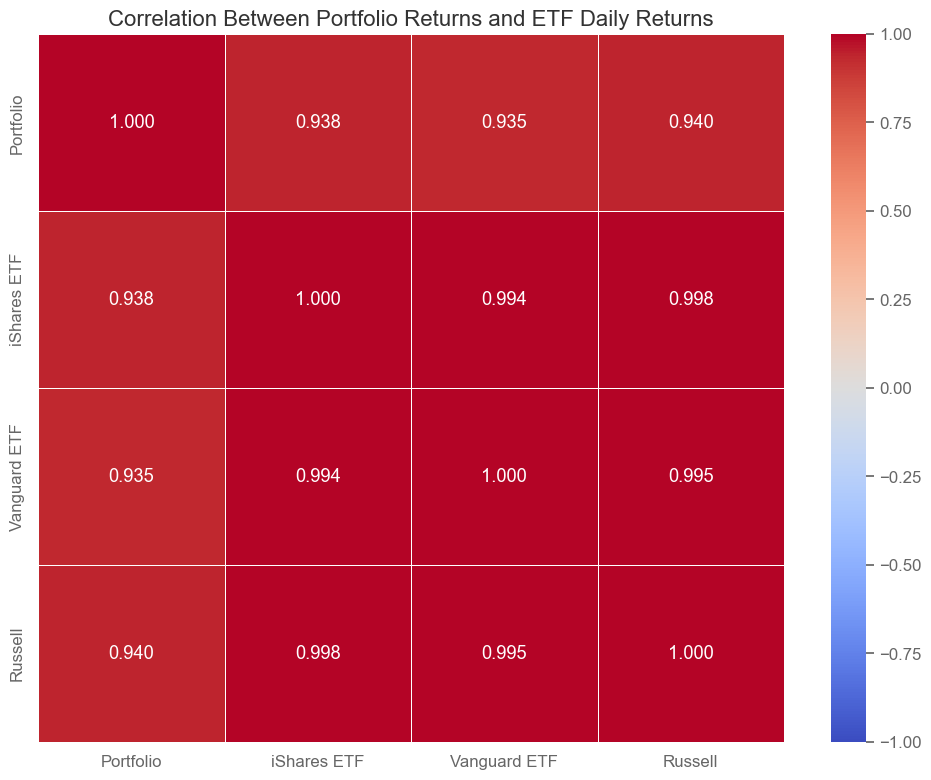

Correlation Values:
              Portfolio  iShares ETF  Vanguard ETF   Russell
Portfolio      1.000000     0.938047      0.935478  0.940207
iShares ETF    0.938047     1.000000      0.994267  0.998484
Vanguard ETF   0.935478     0.994267      1.000000  0.994629
Russell        0.940207     0.998484      0.994629  1.000000


In [100]:
# Create a DataFrame with all return series aligned by date
combined_returns = pd.DataFrame({
    'Portfolio': df_test['Portfolio'],
    'iShares ETF': df_test['etf_daily_return_ishares'],
    'Vanguard ETF': df_test['etf_daily_return_van'],
    'Russell': df_test['daily_return'],
})

# Drop any rows with NaN values
combined_returns = combined_returns.dropna()

# Calculate correlation matrix
correlation_matrix = combined_returns.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.3f')
plt.title('Correlation Between Portfolio Returns and ETF Daily Returns', fontsize=16)
plt.tight_layout()
plt.show()

# Print correlation values
print("Correlation Values:")
print(correlation_matrix)

In [101]:
oracle_returns = regime_to_portfolio_returns(df_test,'Portfolio', regime_col='Oracle', t_bills_col='US3MBill')
xgb_returns = regime_to_portfolio_returns(df_test,'Portfolio', regime_col='XGB_regime', t_bills_col='US3MBill')
hmm_returns = regime_to_portfolio_returns(df_test,'Portfolio', regime_col='HMM_regime', t_bills_col='US3MBill')
vote_xh_returns = regime_to_portfolio_returns(df_test,'Portfolio', regime_col='Vote_regime_XH', t_bills_col='US3MBill')
bagging_returns = regime_to_portfolio_returns(df_test,'Portfolio', regime_col='BAG_regime', t_bills_col='US3MBill')
vote_bh_returns = regime_to_portfolio_returns(df_test,'Portfolio', regime_col='Vote_regime_BH', t_bills_col='US3MBill')
buy_hold_returns = df_test['Portfolio']

In [102]:
oracle_metrics = compute_quantstats_metrics(oracle_returns)
xgb_metrics = compute_quantstats_metrics(xgb_returns)
hmm_metrics = compute_quantstats_metrics(hmm_returns)
buy_hold_metrics = compute_quantstats_metrics(buy_hold_returns)
bag_returns= compute_quantstats_metrics(bagging_returns)
vote_xh_metrics = compute_quantstats_metrics(vote_xh_returns)
vote_bh_metrics = compute_quantstats_metrics(vote_bh_returns)



print("Performance Metrics (Test Set) Portfolio:")
print("Tested from:",test1, " to ",test2)
print("Oracle:", oracle_metrics )
print("Buy & Hold:", buy_hold_metrics )
print("XGBoost:", xgb_metrics )
print("HMM:", hmm_metrics )
print("Vote_XH:", vote_xh_metrics )
print("Bagging:", bag_returns )
print("Vote_BH:", vote_bh_metrics )


Performance Metrics (Test Set) Portfolio:
Tested from: 2020-02-01 00:00:00  to  2025-01-01
Oracle: {'Annualized Return (%)': 26.38650877040598, 'Cumulative Return (%)': 130.36139454880322, 'Annualized Risk (%)': 20.60494441819124, 'Max Drawdown (%)': -14.309932934879587, 'Ulcer Index (%)': 4.516242381451999, 'Sharpe Ratio': 1.749689239895256, 'Sortino Ratio': 2.7646111691620683, 'Calmar Ratio': 1.843929590060515, 'Gain/Pain Ratio': 0.34955435638566984, 'Win Rate (%)': 57.996768982229405, 'Profit Factor': 1.3495543563856698}
Buy & Hold: {'Annualized Return (%)': 19.87636277175442, 'Cumulative Return (%)': 90.79474402324546, 'Annualized Risk (%)': 21.760079390082367, 'Max Drawdown (%)': -20.692343136970592, 'Ulcer Index (%)': 6.477317301200249, 'Sharpe Ratio': 1.3156890150477023, 'Sortino Ratio': 2.021393306856731, 'Calmar Ratio': 0.9605660722028972, 'Gain/Pain Ratio': 0.24555699771118739, 'Win Rate (%)': 53.87096774193548, 'Profit Factor': 1.2455569977111873}
XGBoost: {'Annualized Retur